In [1]:
#Importing the necessary libraries
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sklearn

In [2]:
def readAsArray(img):
  band1 = img.GetRasterBand(1).ReadAsArray()
  return(band1)

In [3]:
# Reshaping the images
def reshape_images():
  reshaped_images=[]
  for i in range(len(images)):
    
    new_shape = (images[i].shape[0] * images[i].shape[1], images[i].shape[2])
    new_image = images[i][:, :, :1].reshape(new_shape)
    reshaped_images.append(new_image)

  #concatenating all the arrays
  combined_image = reshaped_images[0]
  for i in range(1, len(reshaped_images)):
    combined_image = np.concatenate((combined_image, reshaped_images[i]), axis=0)

  # Removing nan values
  train_image = np.nan_to_num(combined_image)
  return train_image

In [4]:
# Plot Function
def plot_image(plt_img):
  plt.figure()
  plt.imshow(plt_img)
  plt.show()

In [ ]:
#List of images
images_list = []
for i in range(2,101):
  images_list.append(str(i)+ "_P_256.tif")
  images_list.append(str(i) +"_A_256.tif")

images = []

# Opening the satellite images
for img_name in images_list:
    img = gdal.Open('./ALL_FLOOD_256/'+ img_name)
    modified_img = readAsArray(img)
    modified_img = modified_img.reshape((modified_img.shape[0], modified_img.shape[1], 1))
    images.append(modified_img)

train_image = reshape_images()

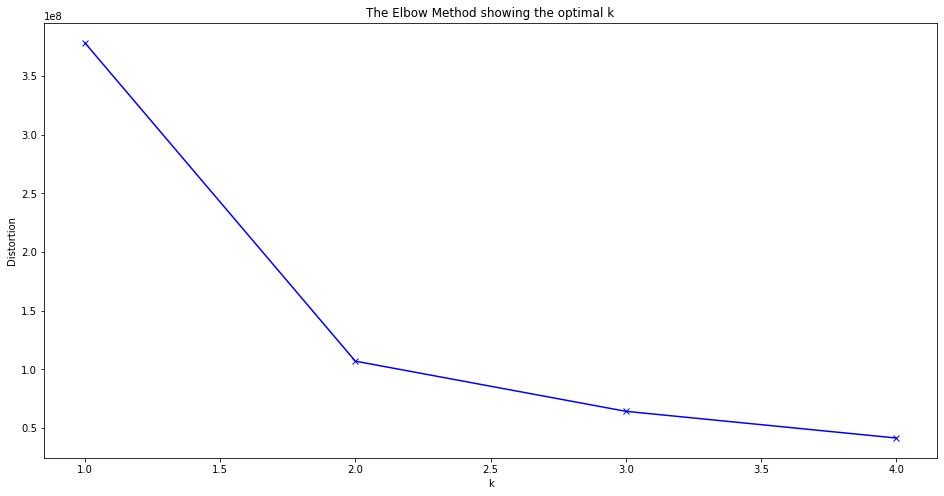

In [7]:
# Using Elbow-method to determine the optimum number of clusters for K-Means method

from sklearn.cluster import KMeans
distortions = []

K = range(1,5)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(train_image)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [5]:
#Running the KMeans Algorithm
kmeans_model = KMeans(n_clusters=2)
kmeans_model = kmeans_model.fit(train_image)

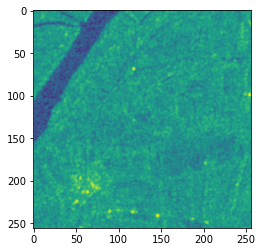

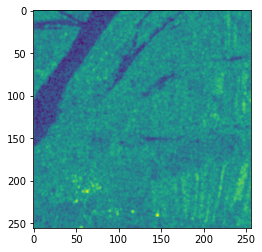

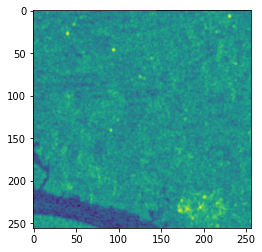

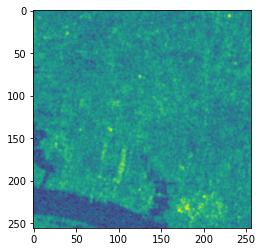

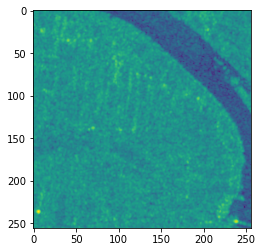

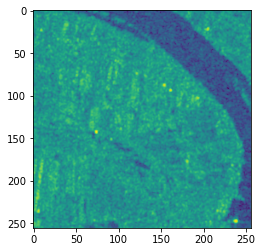

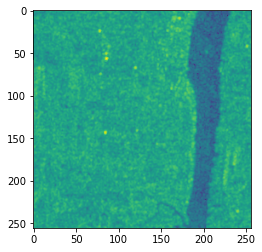

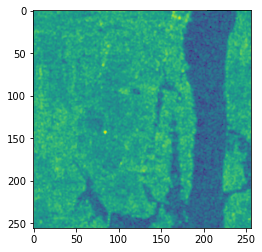

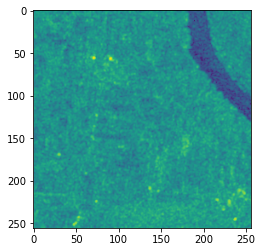

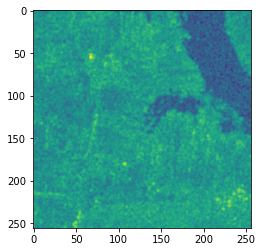

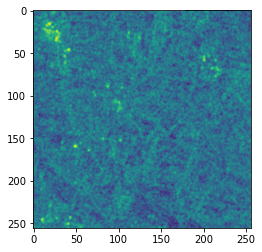

In [8]:
# Visualizing all the images
for img in images[:11]:
  plot_image(img)

In [9]:
# Opening the test images
imgP = gdal.Open("./ALL_FLOOD_256/1_P_256.tif")
imgA = gdal.Open("./ALL_FLOOD_256/1_A_256.tif")

before_img = readAsArray(imgP)
after_img = readAsArray(imgA)

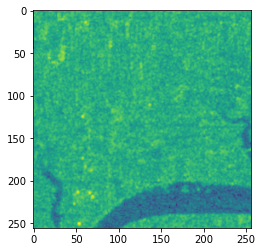

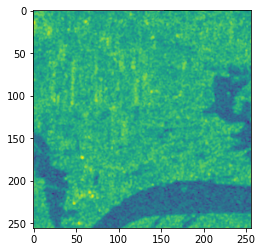

In [10]:
# Visualizing the before and after food images
plot_image(before_img)
plot_image(after_img)

In [11]:
# Reshaping the test images
before_img = np.nan_to_num(before_img)
after_img = np.nan_to_num(after_img)

before_img = before_img.reshape((before_img.shape[0], before_img.shape[1], 1))
after_img = after_img.reshape((after_img.shape[0], after_img.shape[1], 1))

new_before_shape = (before_img.shape[0] * before_img.shape[1], before_img.shape[2])
X_before = before_img[:, :, :1].reshape(new_before_shape)

new_after_shape = (after_img.shape[0] * after_img.shape[1], after_img.shape[2])
X_after = after_img[:, :, :1].reshape(new_after_shape)

In [12]:
# Running KMeans Algorithm on test before image

kmeans_before_labels = kmeans_model.fit_predict(X_before)
kmeans_before_labels_reshaped = kmeans_before_labels.reshape(before_img[:, :, 0].shape)

In [13]:
# Running KMeans Algorithm on test after image

kmeans_after_labels = kmeans_model.fit_predict(X_after)
kmeans_after_labels_reshaped = kmeans_after_labels.reshape(after_img[:, :, 0].shape)

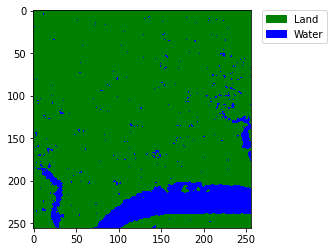

In [16]:
# Visualizing the clusters formed for pre-flood image

import matplotlib.patches as mpatches
import matplotlib.colors as colo

plt.figure()

custom = colo.ListedColormap(["green", "blue"])

im_before = plt.imshow(kmeans_before_labels_reshaped, cmap = custom)

values = np.unique(kmeans_before_labels_reshaped.ravel())

# Getting the colors of the values, according to the colormap used by imshow
colors = [im_before.cmap(im_before.norm(value)) for value in values]

# Creating a patch (proxy artist) for every color 
labels = ["Land", "Water"]
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(values)) ]
# Putting those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

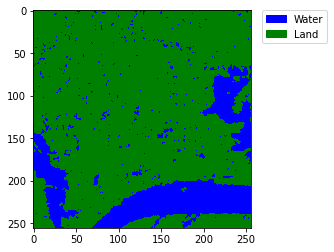

In [17]:
# Visualizing the clusters formed for post-flood image

plt.figure()

custom = colo.ListedColormap(["blue", "green"])

im_after = plt.imshow(kmeans_after_labels_reshaped, cmap = custom)

values = np.unique(kmeans_after_labels_reshaped.ravel())

# Getting the colors of the values, according to the colormap used by imshow
colors = [im_after.cmap(im_after.norm(value)) for value in values]

# Creating a patch (proxy artist) for every color 
labels = ["Water", "Land"]
patches = [ mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(values)) ]
# Putting those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [18]:
# Calculating water percentage for before image

arr_before = np.unique(kmeans_before_labels, return_counts=True)
key_before, val_before = arr_before
water_before = val_before[1]/(val_before[0] + val_before[1]) * 100
print("%.2f" %water_before, "%")

11.03 %


In [19]:
# Calculating water percentage for after image

arr_after = np.unique(kmeans_after_labels, return_counts=True)
key_after, val_after = arr_after
water_after = val_after[0]/(val_after[0] + val_after[1]) * 100
print("%.2f" %water_after, "%")

19.46 %


In [20]:
# Calculating Flood Increase

flood_increase = water_after - water_before
print("%.2f" %flood_increase, "%")

8.43 %


In [39]:
# Calculating silhouette score for comparision

z = sklearn.metrics.silhouette_score(X_after, kmeans_after_labels)
print("Accuracy:", ((z+1)/2)*100, "%")

Accuracy: 84.65270478459017 %


In [32]:
# sklearn.metrics.calinski_harabasz_score(X_after, kmeans_after_labels)

156050.09253074098

In [33]:
# sklearn.metrics.davies_bouldin_score(X_after, kmeans_after_labels)

0.4211975212506668